In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import math
from sklearn.preprocessing import normalize
from scipy.spatial import distance

# Loading the data

In [8]:
datasetB_X = pd.read_csv('Set-B.X.csv')
datasetB_Y = pd.read_csv('Set-B.y.csv',names=['Pred'])

# Exploring the data

In [9]:
datasetB_X.head()

,amount,hour1,state1,zip1,custAttr1,field1,custAttr2,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5
0,12.95,0,WA,986,1234567890123456,0,luhxsodzmjhng7@comcast.net,0,0,0,12.95,-723,19,0,0,0,0,0,1
1,38.85,0,WA,980,1234567890123457,3,pfixyiqfpvkcg@zjyxs.net,1,0,0,38.85,5497,14,1,0,0,1,0,1
2,38.85,0,KY,402,1234567890123458,2,shbjoldciswwm@aol.com,1,0,0,38.85,-4420,23,0,0,1,1,0,1
3,12.95,0,CA,958,1234567890123459,3,ipbvtdfkhhfws@sbcglobal.net,0,0,0,12.95,5010,31,0,0,1,0,0,1
4,38.85,0,GA,300,1234567890123460,3,ivfuvxiennhdp@bellsouth.net,1,0,0,38.85,-4074,21,0,0,1,0,0,1


# Dealing with null values

In [14]:
datasetB_Y['Pred'].isnull().values.sum()

0

In [17]:
datasetB_X.isnull().values.sum()

1

In [18]:
datasetB_X['state1'].isnull().values.sum()

1

In [19]:
datasetB_X['state1'].value_counts().head()

CA    19717
FL     8055
TX     6785
NY     6566
GA     4105
Name: state1, dtype: int64

In [20]:
datasetB_X['state1']=datasetB_X['state1'].fillna('CA')

In [21]:
datasetB_X.isnull().values.sum()

0

# Inserting dummy variables

In [24]:
labels1 = datasetB_X['state1'].astype('category').cat.categories.tolist()
replace_map_comp1 = {'state1' : {k: v for k,v in zip(labels1,list(range(1,len(labels1)+1)))}}
datasetB_X.replace(replace_map_comp1, inplace=True)
datasetB_X['state1'].astype('int64')[:5]

0    51
1    51
2    20
3     7
4    13
Name: state1, dtype: int64

In [29]:
datasetB_X = datasetB_X.drop('custAttr2',axis=1)

In [30]:
datasetB_X.head()

,amount,hour1,state1,zip1,custAttr1,field1,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5
0,12.95,0,51,986,1234567890123456,0,0,0,0,12.95,-723,19,0,0,0,0,0,1
1,38.85,0,51,980,1234567890123457,3,1,0,0,38.85,5497,14,1,0,0,1,0,1
2,38.85,0,20,402,1234567890123458,2,1,0,0,38.85,-4420,23,0,0,1,1,0,1
3,12.95,0,7,958,1234567890123459,3,0,0,0,12.95,5010,31,0,0,1,0,0,1
4,38.85,0,13,300,1234567890123460,3,1,0,0,38.85,-4074,21,0,0,1,0,0,1


In [31]:
datasetB_X.shape

(100000, 18)

# Merging X and Y

In [33]:
datasetB=datasetB_X
datasetB['Pred']=datasetB_Y['Pred']
datasetB['Pred'].astype('int64')
datasetB.head()

,amount,hour1,state1,zip1,custAttr1,field1,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,Pred
0,12.95,0,51,986,1234567890123456,0,0,0,0,12.95,-723,19,0,0,0,0,0,1,0
1,38.85,0,51,980,1234567890123457,3,1,0,0,38.85,5497,14,1,0,0,1,0,1,0
2,38.85,0,20,402,1234567890123458,2,1,0,0,38.85,-4420,23,0,0,1,1,0,1,0
3,12.95,0,7,958,1234567890123459,3,0,0,0,12.95,5010,31,0,0,1,0,0,1,0
4,38.85,0,13,300,1234567890123460,3,1,0,0,38.85,-4074,21,0,0,1,0,0,1,0


# Splitting the data

In [35]:
trainB, testB = train_test_split(datasetB, test_size=0.2)

In [36]:
trainB_X=trainB.iloc[:,0:-1]
trainB_Y=trainB.iloc[:,-1:]

In [37]:
testB_X=testB.iloc[:,0:-1]
testB_Y=testB.iloc[:,-1:]

# Normalizing the data (min-max)

In [41]:
norm_trainB=(trainB-trainB.min())/(trainB.max()-trainB.min())

In [42]:
norm_trainB.shape

(80000, 19)

In [43]:
norm_testB=(testB-testB.min())/(testB.max()-testB.min())

In [44]:
norm_testB.shape

(20000, 19)

# Logistic regression

In [115]:
X_trainB = norm_trainB.iloc[:,0:-1]
ones = np.ones([X_trainB.shape[0],1])
X_trainB = np.concatenate((ones,X_trainB),axis=1)

y_trainB = norm_trainB.iloc[:,-1:].values

In [112]:
def sigmoid(x):
    # Activation function used to map any real value between 0 and 1
    return 1 / (1 + np.exp(-x))

def net_input(theta, x):
    # Computes the weighted sum of inputs
    return np.dot(x, theta)

def probability(theta, x):
    # Returns the probability after passing through sigmoid
    return sigmoid(net_input(theta, x))

def computeCost(x, y,theta):
    # Computes the cost function for all the training samples
    m = x.shape[0]
    total_cost = -(1 / m) * np.sum(y * np.log(probability(theta, x)) + (1 - y) * np.log(1 - probability(theta, x)))
    return total_cost

In [113]:
def minigradientDescent(X,y,theta,iters,alpha):
    #cost = np.zeros(iters)
    for i in range(iters):
        for n in range(0,len(X),128):
            m = 128
            grad= (1 / m) * np.dot(X[n:(n+128)].T, sigmoid(net_input(theta,   X[n:(n+128)])) - y[n:(n+128)])

            theta = theta - (alpha * grad)

            cost = computeCost(X[n:(n+128)], y[n:(n+128)], theta)
    return theta,cost

In [ ]:
alpha=0.1
iters=100
theta = np.zeros((X_trainA.shape[1],1))

In [ ]:
kf = KFold(n_splits = 10, random_state = None, shuffle = False)
accuracy_list = []
tc = []
for train_in, test_in in kf.split(X_trainB):
    x = X_trainB[train_in]
    y = y_trainB[train_in]
    x_te = X_trainB[test_in]
    y_te = y_trainB[test_in]
    theta, cost = minigradientDescent(x,y,theta,iters,alpha)
    
    y_pred = probability(theta, x_te)
    y_pred[y_pred>0.5]=1
    y_pred[y_pred<=0.5]=0
    
    TP=0;FN=0;FP=0;TN=0
    for i in range(0,len(y_pred)):
        if ((y_pred[i]==1)&(y_te[i]==1)):
            TP=TP+1
        if ((y_pred[i]==0)&(y_te[i]==1)):
            FN=FN+1
        if ((y_pred[i]==1)&(y_te[i]==0)):
            FP=FP+1
        if ((y_pred[i]==0)&(y_te[i]==0)):
            TN=TN+1

    Accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracy_list.append(Accuracy)

In [79]:
alpha=0.01
iters=3000
theta = np.zeros((X_trainB.shape[1],1))

In [ ]:
#running the gd and cost function
g,cost = minigradientDescent(X_trainB,y_trainB,theta,iters,alpha)
print(g)
print(g.shape)

In [82]:
X_testB=norm_testB.iloc[:,0:-1]
ones = np.ones([X_testB.shape[0],1])
X_testB = np.concatenate((ones,X_testB),axis=1)

y_testB = norm_testB.iloc[:,-1:].values

In [83]:
test_prob=probability(g,X_testB)

In [84]:
test_pred=np.copy(test_prob)
test_pred[test_pred>0.5]=1
test_pred[test_pred<=0.5]=0

In [139]:
def confuse(y_act,y_pred):
    TP=0;FN=0;FP=0;TN=0
    for i in range(0,len(y_pred)):
        if ((y_pred[i]==1)&(y_act[i]==1)):
            TP=TP+1
        if ((y_pred[i]==0)&(y_act[i]==1)):
            FN=FN+1
        if ((y_pred[i]==1)&(y_act[i]==0)):
            FP=FP+1
        if ((y_pred[i]==0)&(y_act[i]==0)):
            TN=TN+1

    Accuracy=(TP+TN)/(TP+TN+FP+FN)
    print("Accuracy:",Accuracy)

    print("Confusion matrix:")
    print("TP: ",TP,"FN:",FN)
    print("FP: ",FP,"TN:",TN)

    if (TP!=0):
        precision=TP/(TP+FP)
        print("Precision:",precision)

    recall=TP/(TP+FN)
    print("Recall:",recall)

    if (TP!=0):
        f1=(2*precision*recall)/(precision+recall)
        print("F1 score:",f1)

    TPR=TP/(TP+FN)
    print("TPR:",TPR)
    FPR=FP/(FP+TN)
    print("FPR:",FPR)

def roc(y_act,probs):
    fpr, tpr, thresholds = metrics.roc_curve(y_act, probs)

    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [140]:
confuse(y_testB,test_pred)

Accuracy: 0.9724
Confusion matrix:
TP:  0 FN: 552
FP:  0 TN: 19448
Recall: 0.0
TPR: 0.0
FPR: 0.0


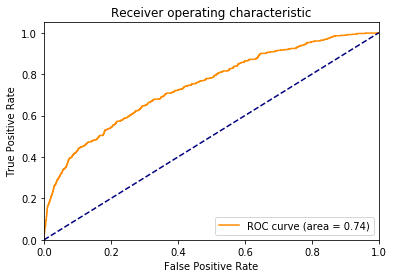

In [141]:
roc(y_testB,test_prob)

In [ ]:
train_prob= probability(g,X_trainB)

In [ ]:
train_pred=np.copy(train_prob)
train_pred[train_pred>0.5]=1
train_pred[train_pred<=0.5]=0

In [ ]:
np.unique(test_pred,return_counts=True)

In [142]:
confuse(y_trainB,test_pred)

Accuracy: 0.97395
Confusion matrix:
TP:  0 FN: 521
FP:  0 TN: 19479
Recall: 0.0
TPR: 0.0
FPR: 0.0


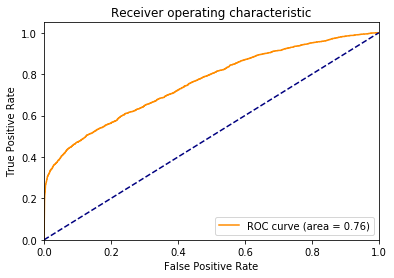

In [143]:
roc(y_trainB,train_prob)

There is no sign of overfitting as the accuracy over training and teting data are both high.

To deal with skewed distribution I would adopt 2 methods:
1. Use cost matrix
OR
2. Reduce data to make sure that positive category is atleast a significant portion ,say 30% 

# Task 2 : Naive Bayes Classifier

In [87]:
trainB_X.head()

,amount,hour1,state1,zip1,custAttr1,field1,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5
77369,38.85,22,47,782,1234567890158846,2,0,22,1,38.85,3575,10,0,0,0,0,1,1
18229,49.95,18,23,210,1234567890138208,3,1,18,0,49.95,-6231,9,0,0,0,0,0,1
15307,11.01,21,25,496,1234567890135957,3,1,21,0,11.01,4014,23,0,0,0,0,0,1
27636,31.08,22,13,307,1234567890145337,2,1,22,1,31.08,3661,25,0,0,1,1,0,2
67305,12.95,0,13,317,1234567890174128,3,0,0,1,12.95,5329,21,0,0,1,1,0,1


In [94]:
trainB_X.shape

(80000, 18)

In [125]:
#number of zeros and ones in Y
pred_zeros=trainB_Y['Pred'].value_counts()[0]
pred_ones=trainB_Y['Pred'].value_counts()[1]

In [126]:
# "Amount" column
amount_mean_zeros = trainB_X.iloc[(trainB_Y['Pred']==0).values.tolist(),[0]].mean()
amount_std_zeros = trainB_X.iloc[(trainB_Y['Pred']==0).values.tolist(),[0]].std()

amount_mean_ones = trainB_X.iloc[(trainB_Y['Pred']==1).values.tolist(),[0]].mean()
amount_std_ones = trainB_X.iloc[(trainB_Y['Pred']==1).values.tolist(),[0]].std()

# "custAttr1" column
cust_mean_zeros = trainB_X.iloc[(trainB_Y['Pred']==0).values.tolist(),[4]].mean()
cust_std_zeros = trainB_X.iloc[(trainB_Y['Pred']==0).values.tolist(),[4]].std()

cust_mean_ones = trainB_X.iloc[(trainB_Y['Pred']==1).values.tolist(),[4]].mean()
cust_std_ones = trainB_X.iloc[(trainB_Y['Pred']==1).values.tolist(),[4]].std()

# "Total" column
total_mean_zeros = trainB_X.iloc[(trainB_Y['Pred']==0).values.tolist(),[9]].mean()
total_std_zeros = trainB_X.iloc[(trainB_Y['Pred']==0).values.tolist(),[9]].std()

total_mean_ones = trainB_X.iloc[(trainB_Y['Pred']==1).values.tolist(),[9]].mean()
total_std_ones = trainB_X.iloc[(trainB_Y['Pred']==1).values.tolist(),[9]].std()

In [130]:
overall_freq_dict={}
overall_prob_dict={}
k_list = {}

for i in range(0,trainB_X.shape[1]):
    if ((i!=0)&(i!=9)&(i!=4)):
        unique1, counts1 = np.unique(trainB_X.iloc[(trainB_Y['Pred']==0).values.tolist(),[i]], return_counts=True)
        unique2, counts2 = np.unique(trainB_X.iloc[(trainB_Y['Pred']==1).values.tolist(),[i]], return_counts=True)
        
        k = len(trainB_X.iloc[:,i].unique())
        
        d1=dict(zip(unique1,counts1))
        d2=dict(zip(unique2,counts2))
        
        freq_dict={}
        for key in d1:
            if key in d2:
                freq_dict[key]=(d1[key],d2[key])
            else:
                freq_dict[key]=(d1[key],0)
        for key in d2:
            if key in d1:
                freq_dict[key]=(d1[key],d2[key])
            else:
                freq_dict[key]=(0,d2[key])
        
        probs1 = (counts1 + 1) / (pred_zeros + k)
        probs2 = (counts2 + 1) / (pred_ones + k)
        
        p1=dict(zip(unique1,probs1))
        p2=dict(zip(unique2,probs2))
        
        prob_dict={}
        for key in p1:
            if key in p2:
                prob_dict[key]=(p1[key],p2[key])
            else:
                prob_dict[key]=(p1[key],0)
        for key in p2:
            if key in p1:
                prob_dict[key]=(p1[key],p2[key])
            else:
                prob_dict[key]=(0,p2[key])
        
        overall_freq_dict[i] = freq_dict
        overall_prob_dict[i] = prob_dict
        
        k_list[i] = k

In [ ]:
kf = KFold(n_splits = 5, random_state = None, shuffle = False)

for train_in, test_in in kf.split(trainB_X):
    x = trainB_X.iloc[train_in,:]
    y = trainB_Y.iloc[train_in,:]
    x_te = trainB_X.iloc[test_in,:]
    y_te = trainB_Y.iloc[test_in,:]
    
    print(type(x))
    
    overall_freq_dict={}
    overall_prob_dict={}
    k_list = {}

    for i in range(0,x.shape[1]):
        if ((i!=0)&(i!=9)&(i!=4)):
            unique1, counts1 = np.unique(trainB_X.iloc[(trainB_Y['Pred']==0).values.tolist(),[i]], return_counts=True)
            unique2, counts2 = np.unique(trainB_X.iloc[(trainB_Y['Pred']==1).values.tolist(),[i]], return_counts=True)

            k = len(trainB_X.iloc[:,i].unique())

            d1=dict(zip(unique1,counts1))
            d2=dict(zip(unique2,counts2))

            freq_dict={}
            for key in d1:
                if key in d2:
                    freq_dict[key]=(d1[key],d2[key])
                else:
                    freq_dict[key]=(d1[key],0)
            for key in d2:
                if key in d1:
                    freq_dict[key]=(d1[key],d2[key])
                else:
                    freq_dict[key]=(0,d2[key])

            probs1 = (counts1 + 1) / (pred_zeros + k)
            probs2 = (counts2 + 1) / (pred_ones + k)

            p1=dict(zip(unique1,probs1))
            p2=dict(zip(unique2,probs2))

            prob_dict={}
            for key in p1:
                if key in p2:
                    prob_dict[key]=(p1[key],p2[key])
                else:
                    prob_dict[key]=(p1[key],0)
            for key in p2:
                if key in p1:
                    prob_dict[key]=(p1[key],p2[key])
                else:
                    prob_dict[key]=(0,p2[key])

            overall_freq_dict[i] = freq_dict
            overall_prob_dict[i] = prob_dict

            k_list[i] = k
            
    prob_zero_list=[]
    for row_index in range(0,testB_X.shape[0]):
        prob_zero = 0
        for col_index in range(0,testB_X.shape[1]):
            value = testB_X.iloc[row_index][col_index]
            if ((col_index!=0)&(col_index!=9)&(col_index!=4)):
                if value in overall_prob_dict[col_index]:
                    if overall_freq_dict[col_index][value][0]!=0:
                        prob_zero = prob_zero + math.log(overall_prob_dict[col_index][value][0]) #for pred = 0
                    else:
                        prob_zero = prob_zero + math.log(1 / (pred_zeros + k_list[col_index]))
                else:
                    prob_zero = prob_zero + math.log(1 / (pred_zeros + k_list[col_index]))
            elif (col_index==0):
                prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(amount_std_zeros,2))) * math.exp(-(pow(value-amount_mean_zeros,2)/(2*pow(amount_std_zeros,2)))))
            elif (col_index==9):
                prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(total_std_zeros,2))) * math.exp(-(pow(value-total_mean_zeros,2)/(2*pow(total_std_zeros,2)))))
            elif (col_index==4):
                prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(cust_std_zeros,2))) * math.exp(-(pow(value-cust_mean_zeros,2)/(2*pow(cust_std_zeros,2)))))

        prob_zero = prob_zero + math.log(pred_zeros/(pred_zeros+pred_ones))
        prob_zero_list.append(prob_zero)

    prob_one_list=[]
    for row_index in range(0,testB_X.shape[0]):
        prob_one = 0
        for col_index in range(0,testB_X.shape[1]):
            value = testB_X.iloc[row_index][col_index]
            if ((col_index!=0)&(col_index!=9)&(col_index!=4)):
                if value in overall_prob_dict[col_index]:
                    if overall_freq_dict[col_index][value][1]!=0:
                        prob_one = prob_one + math.log(overall_prob_dict[col_index][value][1]) #for pred = 1
                    else:
                        prob_one = prob_one + math.log(1 / (pred_ones + k_list[col_index]))
                else:
                    prob_one = prob_one + math.log(1 / (pred_ones + k_list[col_index]))
            elif (col_index==0):
                prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(amount_std_ones,2))) * math.exp(-(pow(value-amount_mean_ones,2)/(2*pow(amount_std_ones,2)))))
            elif (col_index==9):
                prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(total_std_ones,2))) * math.exp(-(pow(value-total_mean_ones,2)/(2*pow(total_std_ones,2)))))
            elif (col_index==4):
                prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(cust_std_ones,2))) * math.exp(-(pow(value-cust_mean_ones,2)/(2*pow(cust_std_ones,2)))))

        prob_one = prob_one + math.log(pred_ones/(pred_zeros+pred_ones))
        prob_one_list.append(prob_one)

    prob_zero_np = np.asarray(prob_zero_list)
    prob_one_np = np.asarray(prob_one_list)

    test_pred_nb=np.zeros([x_te.shape[0]])

    test_pred_nb[prob_zero_np>prob_one_np]=0
    test_pred_nb[prob_zero_np<prob_one_np]=1

    np.unique(test_pred_nb,return_counts=True)

    confuse(y_te,test_pred_nb)

In [95]:
prob_zero_list=[]
for row_index in range(0,testB_X.shape[0]):
    prob_zero = 0
    for col_index in range(0,testB_X.shape[1]):
        value = testB_X.iloc[row_index][col_index]
        if ((col_index!=0)&(col_index!=9)&(col_index!=4)):
            if value in overall_prob_dict[col_index]:
                if overall_freq_dict[col_index][value][0]!=0:
                    prob_zero = prob_zero + math.log(overall_prob_dict[col_index][value][0]) #for pred = 0
                else:
                    prob_zero = prob_zero + math.log(1 / (pred_zeros + k_list[col_index]))
            else:
                prob_zero = prob_zero + math.log(1 / (pred_zeros + k_list[col_index]))
        elif (col_index==0):
            prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(amount_std_zeros,2))) * math.exp(-(pow(value-amount_mean_zeros,2)/(2*pow(amount_std_zeros,2)))))
        elif (col_index==9):
            prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(total_std_zeros,2))) * math.exp(-(pow(value-total_mean_zeros,2)/(2*pow(total_std_zeros,2)))))
        elif (col_index==4):
            prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(cust_std_zeros,2))) * math.exp(-(pow(value-cust_mean_zeros,2)/(2*pow(cust_std_zeros,2)))))
        
    prob_zero = prob_zero + math.log(pred_zeros/(pred_zeros+pred_ones))
    prob_zero_list.append(prob_zero)

In [96]:
prob_one_list=[]
for row_index in range(0,testB_X.shape[0]):
    prob_one = 0
    for col_index in range(0,testB_X.shape[1]):
        value = testB_X.iloc[row_index][col_index]
        if ((col_index!=0)&(col_index!=9)&(col_index!=4)):
            if value in overall_prob_dict[col_index]:
                if overall_freq_dict[col_index][value][1]!=0:
                    prob_one = prob_one + math.log(overall_prob_dict[col_index][value][1]) #for pred = 1
                else:
                    prob_one = prob_one + math.log(1 / (pred_ones + k_list[col_index]))
            else:
                prob_one = prob_one + math.log(1 / (pred_ones + k_list[col_index]))
        elif (col_index==0):
            prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(amount_std_ones,2))) * math.exp(-(pow(value-amount_mean_ones,2)/(2*pow(amount_std_ones,2)))))
        elif (col_index==9):
            prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(total_std_ones,2))) * math.exp(-(pow(value-total_mean_ones,2)/(2*pow(total_std_ones,2)))))
        elif (col_index==4):
            prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(cust_std_ones,2))) * math.exp(-(pow(value-cust_mean_ones,2)/(2*pow(cust_std_ones,2)))))

    prob_one = prob_one + math.log(pred_ones/(pred_zeros+pred_ones))
    prob_one_list.append(prob_one)

In [99]:
prob_zero_np = np.asarray(prob_zero_list)
prob_one_np = np.asarray(prob_one_list)

In [100]:
test_pred_nb=np.zeros([testB_X.shape[0]])

In [101]:
test_pred_nb[prob_zero_np>prob_one_np]=0
test_pred_nb[prob_zero_np<prob_one_np]=1

In [102]:
np.unique(test_pred_nb,return_counts=True)

(array([0., 1.]), array([19499,   501], dtype=int64))

In [103]:
confuse(y_trainB,test_pred_nb)

Accuracy: 0.95
Confusion matrix:
TP:  11 FN: 510
FP:  490 TN: 18989
Precision: 0.021956087824351298
Recall: 0.02111324376199616
F1 score: 0.02152641878669276
TPR: 0.02111324376199616
FPR: 0.02515529544637815


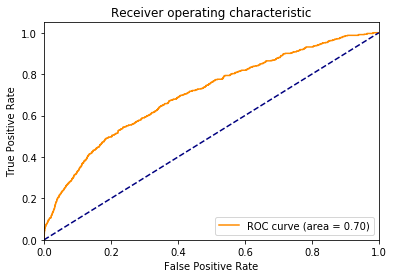

In [123]:
roc(y_testB,prob_one_np)

In [132]:
prob_zero_list=[]
for row_index in range(0,trainB_X.shape[0]):
    prob_zero = 0
    for col_index in range(0,trainB_X.shape[1]):
        value = trainB_X.iloc[row_index][col_index]
        if ((col_index!=0)&(col_index!=9)&(col_index!=4)):
            if value in overall_prob_dict[col_index]:
                if overall_freq_dict[col_index][value][0]!=0:
                    prob_zero = prob_zero + math.log(overall_prob_dict[col_index][value][0]) #for pred = 0
                else:
                    prob_zero = prob_zero + math.log(1 / (pred_zeros + k_list[col_index]))
            else:
                prob_zero = prob_zero + math.log(1 / (pred_zeros + k_list[col_index]))
        elif (col_index==0):
            prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(amount_std_zeros,2))) * math.exp(-(pow(value-amount_mean_zeros,2)/(2*pow(amount_std_zeros,2)))))
        elif (col_index==9):
            prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(total_std_zeros,2))) * math.exp(-(pow(value-total_mean_zeros,2)/(2*pow(total_std_zeros,2)))))
        elif (col_index==4):
            prob_zero = prob_zero + math.log((1/math.sqrt(2*math.pi*pow(cust_std_zeros,2))) * math.exp(-(pow(value-cust_mean_zeros,2)/(2*pow(cust_std_zeros,2)))))
        
    prob_zero = prob_zero + math.log(pred_zeros/(pred_zeros+pred_ones))
    prob_zero_list.append(prob_zero)

In [133]:
prob_one_list=[]
for row_index in range(0,trainB_X.shape[0]):
    prob_one = 0
    for col_index in range(0,trainB_X.shape[1]):
        value = trainB_X.iloc[row_index][col_index]
        if ((col_index!=0)&(col_index!=9)&(col_index!=4)):
            if value in overall_prob_dict[col_index]:
                if overall_freq_dict[col_index][value][1]!=0:
                    prob_one = prob_one + math.log(overall_prob_dict[col_index][value][1]) #for pred = 1
                else:
                    prob_one = prob_one + math.log(1 / (pred_ones + k_list[col_index]))
            else:
                prob_one = prob_one + math.log(1 / (pred_ones + k_list[col_index]))
        elif (col_index==0):
            prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(amount_std_ones,2))) * math.exp(-(pow(value-amount_mean_ones,2)/(2*pow(amount_std_ones,2)))))
        elif (col_index==9):
            prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(total_std_ones,2))) * math.exp(-(pow(value-total_mean_ones,2)/(2*pow(total_std_ones,2)))))
        elif (col_index==4):
            prob_one = prob_one + math.log((1/math.sqrt(2*math.pi*pow(cust_std_ones,2))) * math.exp(-(pow(value-cust_mean_ones,2)/(2*pow(cust_std_ones,2)))))
        
    prob_one = prob_one + math.log(pred_ones/(pred_zeros+pred_ones))
    prob_one_list.append(prob_one)

In [ ]:
prob_zero_np = np.asarray(prob_zero_list)
prob_one_np = np.asarray(prob_one_list)

train_pred_nb=np.zeros([trainB_X.shape[0]])

train_pred_nb[prob_zero_np>prob_one_np]=0
train_pred_nb[prob_zero_np<prob_one_np]=1

np.unique(train_pred_nb,return_counts=True)

In [145]:
confuse(y_trainB,train_pred_nb)

Accuracy: 0.9721625
Confusion matrix:
TP:  854 FN: 1248
FP:  979 TN: 76919
Precision: 0.46590289143480634
Recall: 0.40627973358705993
F1 score: 0.4340533672172808
TPR: 0.40627973358705993
FPR: 0.012567716757811497


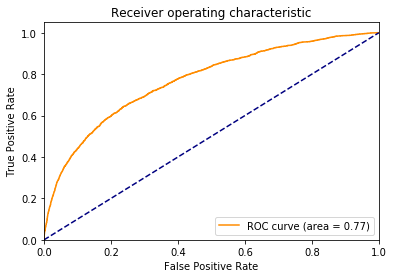

In [146]:
roc(y_trainB,prob_one_np)

There is no sign of overfitting as the accuracy over training and teting data are both high.

To deal with skewed distribution I would adopt 2 methods:
1. Use cost matrix
OR
2. Reduce data to make sure that positive category is atleast a significant portion ,say 30% 

# kNN Clasifier

In [105]:
print(trainB_X.shape)
trainB_X.head()

(80000, 18)


,amount,hour1,state1,zip1,custAttr1,field1,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5
77369,38.85,22,47,782,1234567890158846,2,0,22,1,38.85,3575,10,0,0,0,0,1,1
18229,49.95,18,23,210,1234567890138208,3,1,18,0,49.95,-6231,9,0,0,0,0,0,1
15307,11.01,21,25,496,1234567890135957,3,1,21,0,11.01,4014,23,0,0,0,0,0,1
27636,31.08,22,13,307,1234567890145337,2,1,22,1,31.08,3661,25,0,0,1,1,0,2
67305,12.95,0,13,317,1234567890174128,3,0,0,1,12.95,5329,21,0,0,1,1,0,1


In [106]:
print(testB_X.shape)
testB_X.head()

(20000, 18)


,amount,hour1,state1,zip1,custAttr1,field1,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5
16629,12.95,14,7,913,1234567890136955,3,0,14,1,12.95,-2062,6,0,0,0,0,0,1
85521,12.95,14,11,197,1234567890187042,0,0,14,1,12.95,2759,6,1,0,0,0,0,1
21143,12.95,22,32,681,1234567890140411,3,0,22,1,12.95,4552,8,0,0,1,1,0,1
42110,12.95,16,18,462,1234567890156076,2,0,16,0,12.95,4660,22,0,0,1,1,0,1
54476,10.36,16,6,852,1234567890125940,3,0,16,1,10.36,2815,9,0,0,1,1,0,1


In [107]:
train_red_no = 3000

trainB_np=np.zeros((train_red_no,trainB_X.shape[1]))
for train_row_index in range(0,train_red_no):
    trainB_sample_np = trainB_X.iloc[train_row_index,:].values
    trainB_np[train_row_index] = trainB_sample_np / np.linalg.norm(trainB_sample_np)

In [109]:
knn_table={}
for test_row_index in range(0,testB_X.shape[0]):
    
    testB_sample_np = testB_X.iloc[test_row_index,:].values
    testB_sample_np = testB_sample_np / np.linalg.norm(testB_sample_np)
    
    knn_table[test_row_index] = []
    
    for train_row_index in range(0,train_red_no):
        
        d = distance.euclidean(trainB_np[train_row_index],testB_sample_np)
        c = trainB_Y.iloc[train_row_index,:].values[0]
        
        knn_table[test_row_index].append((d,c))

In [110]:
for test_row_index in knn_table:
    knn_table[test_row_index] = sorted(knn_table[test_row_index], key=lambda tup: tup[0])

In [117]:
for k in range(1,11):
    pred_knn = []

    for test_index in range(0,testB_X.shape[0]):
        zero_count = 0
        one_count = 0

        for count in range(0,k):
            if(knn_table[test_index][count][1]==0):
                zero_count = zero_count + 1
            else:
                one_count = one_count + 1

        if (zero_count > one_count):
            pred_knn.append(0)
        else:
            pred_knn.append(1)
            
    TP=0;FN=0;FP=0;TN=0
    for i in range(0,len(pred_knn)):
        if ((pred_knn[i]==1)&(y_testB[i]==1)):
            TP=TP+1
        if ((pred_knn[i]==0)&(y_testB[i]==1)):
            FN=FN+1
        if ((pred_knn[i]==1)&(y_testB[i]==0)):
            FP=FP+1
        if ((pred_knn[i]==0)&(y_testB[i]==0)):
            TN=TN+1

    Accuracy=(TP+TN)/(TP+TN+FP+FN)
    print("K value:",k,"Accuracy:",Accuracy)
    
    print("Confusion matrix:")
    print("TP: ",TP,"FN:",FN)
    print("FP: ",FP,"TN:",TN)

K value: 1 Accuracy: 0.96115
Confusion matrix:
TP:  97 FN: 455
FP:  322 TN: 19126
K value: 2 Accuracy: 0.9493
Confusion matrix:
TP:  140 FN: 412
FP:  602 TN: 18846
K value: 3 Accuracy: 0.9749
Confusion matrix:
TP:  85 FN: 467
FP:  35 TN: 19413
K value: 4 Accuracy: 0.97375
Confusion matrix:
TP:  91 FN: 461
FP:  64 TN: 19384
K value: 5 Accuracy: 0.9748
Confusion matrix:
TP:  60 FN: 492
FP:  12 TN: 19436
K value: 6 Accuracy: 0.9747
Confusion matrix:
TP:  60 FN: 492
FP:  14 TN: 19434
K value: 7 Accuracy: 0.97425
Confusion matrix:
TP:  48 FN: 504
FP:  11 TN: 19437
K value: 8 Accuracy: 0.97425
Confusion matrix:
TP:  48 FN: 504
FP:  11 TN: 19437
K value: 9 Accuracy: 0.97385
Confusion matrix:
TP:  39 FN: 513
FP:  10 TN: 19438
K value: 10 Accuracy: 0.97385
Confusion matrix:
TP:  39 FN: 513
FP:  10 TN: 19438


In [118]:
k = 1
pred_knn = []

for test_index in range(0,testB_X.shape[0]):
    zero_count = 0
    one_count = 0

    for count in range(0,k):
        if(knn_table[test_index][count][1]==0):
            zero_count = zero_count + 1
        else:
            one_count = one_count + 1

    if (zero_count > one_count):
        pred_knn.append(0)
    else:
        pred_knn.append(1)

In [119]:
confuse(y_testB,pred_knn)

Accuracy: 0.96115
Confusion matrix:
TP:  97 FN: 455
FP:  322 TN: 19126
Precision: 0.2315035799522673
Recall: 0.17572463768115942
F1 score: 0.19979402677651906
TPR: 0.17572463768115942
FPR: 0.01655697243932538


In [1]:
confuse(y_testB,pred_knn)

Accuracy: 0.96115
Confusion matrix:
TP:  97 FN: 455
FP:  322 TN: 19126
Precision: 0.2315035799522673
Recall: 0.17572463768115942
F1 score: 0.19979402677651906
TPR: 0.17572463768115942
FPR: 0.01655697243932538


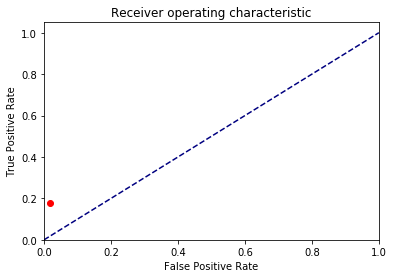

In [120]:
plt.figure()
plt.plot(0.01655697243932538, 0.17572463768115942, 'ro')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [147]:
k = 1
pred_knn = []

for test_index in range(0,testB_X.shape[0]):
    zero_count = 0
    one_count = 0

    for count in range(0,k):
        if(knn_table[test_index][count][1]==0):
            zero_count = zero_count + 1
        else:
            one_count = one_count + 1

    if (zero_count > one_count):
        pred_knn.append(0)
    else:
        pred_knn.append(1)

In [148]:
confuse(y_testB,pred_knn)

Accuracy: 0.96115
Confusion matrix:
TP:  97 FN: 455
FP:  322 TN: 19126
Precision: 0.2315035799522673
Recall: 0.17572463768115942
F1 score: 0.19979402677651906
TPR: 0.17572463768115942
FPR: 0.01655697243932538


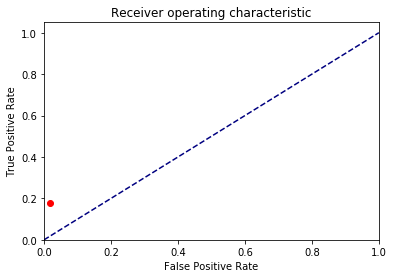

In [149]:
plt.figure()
plt.plot(0.01655697243932538, 0.17572463768115942, 'ro')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

There is no sign of overfitting as the accuracy over training and testing data are both high.

To deal with skewed distribution I would adopt 2 methods:
1. Use cost matrix
OR
2. Reduce data to make sure that positive category is atleast a significant portion ,say 30% 

I would pick logistic regression because:
    1. It has better accuracy rate
    2. Better number of TP values
    3. Computatationally inexpensive than kNN
    4. No overfitting of data